In [16]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro, f_oneway

In [17]:
def get_service_time(distribution_type):
    """Generate service time based on the distribution type.
    
    Args:
    distribution_type (str): service time distribution, either deterministic, exponential, or hyperexponential
    
    Returns:
    service time (float)
    """
    if distribution_type == 'deterministic':
        # M/D/n
        return 1 / SERVICE_RATE  
    
    elif distribution_type == 'exponential':
        # M/M/n
        return np.random.exponential(1 / SERVICE_RATE)
    
    elif distribution_type == 'hyperexponential':
        # Service time distribution with long tail
        np.random.seed()
        if np.random.rand() < 0.75:
            return np.random.exponential(1.0)
        else:
            return np.random.exponential(5.0)
    else:
        raise ValueError(f"Unknown distribution type: {distribution_type}")
    

def customer(env, server, wait_times, priority, service_time_distribution):
    """Customer process: arrives, waits in queue, and gets served.
    
    Args:
    env (simpy.Environment): the simulation environment
    server (simpy.Resource): the server resource
    wait_times (list): list to store wait times
    priority (bool): priority scheduling of the tasks based on service time
    service_time_distribution (str): service time distribution, either deterministic, exponential, or hyperexponential

    Yields:
    simpy.events.Timeout: timeout event that represents the time spent being served
    """
    arrival_time = env.now
    service_time = get_service_time(service_time_distribution)
    
    if priority:
        with server.request(priority=service_time) as request:
            yield request  # Wait for a free server
            wait_time = env.now - arrival_time
            wait_times.append(wait_time)
            yield env.timeout(service_time)  # Time spent being served

    else:
        with server.request() as request:
            yield request  # Wait for a free server
            wait_time = env.now - arrival_time 
            wait_times.append(wait_time) 
            yield env.timeout(service_time)  # Time spent being served

def arrival_generator(env, server, arrival_rate, wait_times, priority, service_time_distribution):
    """Generate customers arriving at a random Poisson distributed interval with lambda = arrival_rate.

    Args:
    env (simpy.Environment): the simulation environment
    server (simpy.Resource): the server resource
    arrival_rate (float): avg arrival rate (following exponential distribution)
    wait_times (list): list to store wait times
    priority (bool): priority scheduling of the tasks based on service time
    service_time_distribution (str): service time distribution, either deterministic, exponential, or hyperexponential

    Yields:
    simpy.events.Timeout: timeout event that generates the next customer arrival
    """
    while True:
        yield env.timeout(np.random.exponential(1 / arrival_rate))
        env.process(customer(env, server, wait_times, priority, service_time_distribution))

def simulate(n_servers, arrival_rate, sim_time, priority, service_time_distribution='exponential'):
    """Simulate an M/M/n or M/D/n queue

    Args:
    n_servers (int): number of servers
    arrival_rate (float): avg arrival rate (following exponential distribution)
    sim_time (int): max simulation time
    priority (bool): priority scheduling of the tasks based on service time
    service_time_distribution (str): choose service time distribution: deterministic, exponential, hyperexponential
    
    Returns:
    average wait time in queue (float)
    """
    env = simpy.Environment()
    if priority:
        server = simpy.PriorityResource(env, capacity=n_servers)  # n servers

    else:
        server = simpy.Resource(env, capacity=n_servers)  # n servers

    wait_times = []  # Collect wait times for analysis
    env.process(arrival_generator(env, server, arrival_rate, wait_times, priority, service_time_distribution))
    env.run(until=sim_time)
    return np.mean(wait_times), wait_times


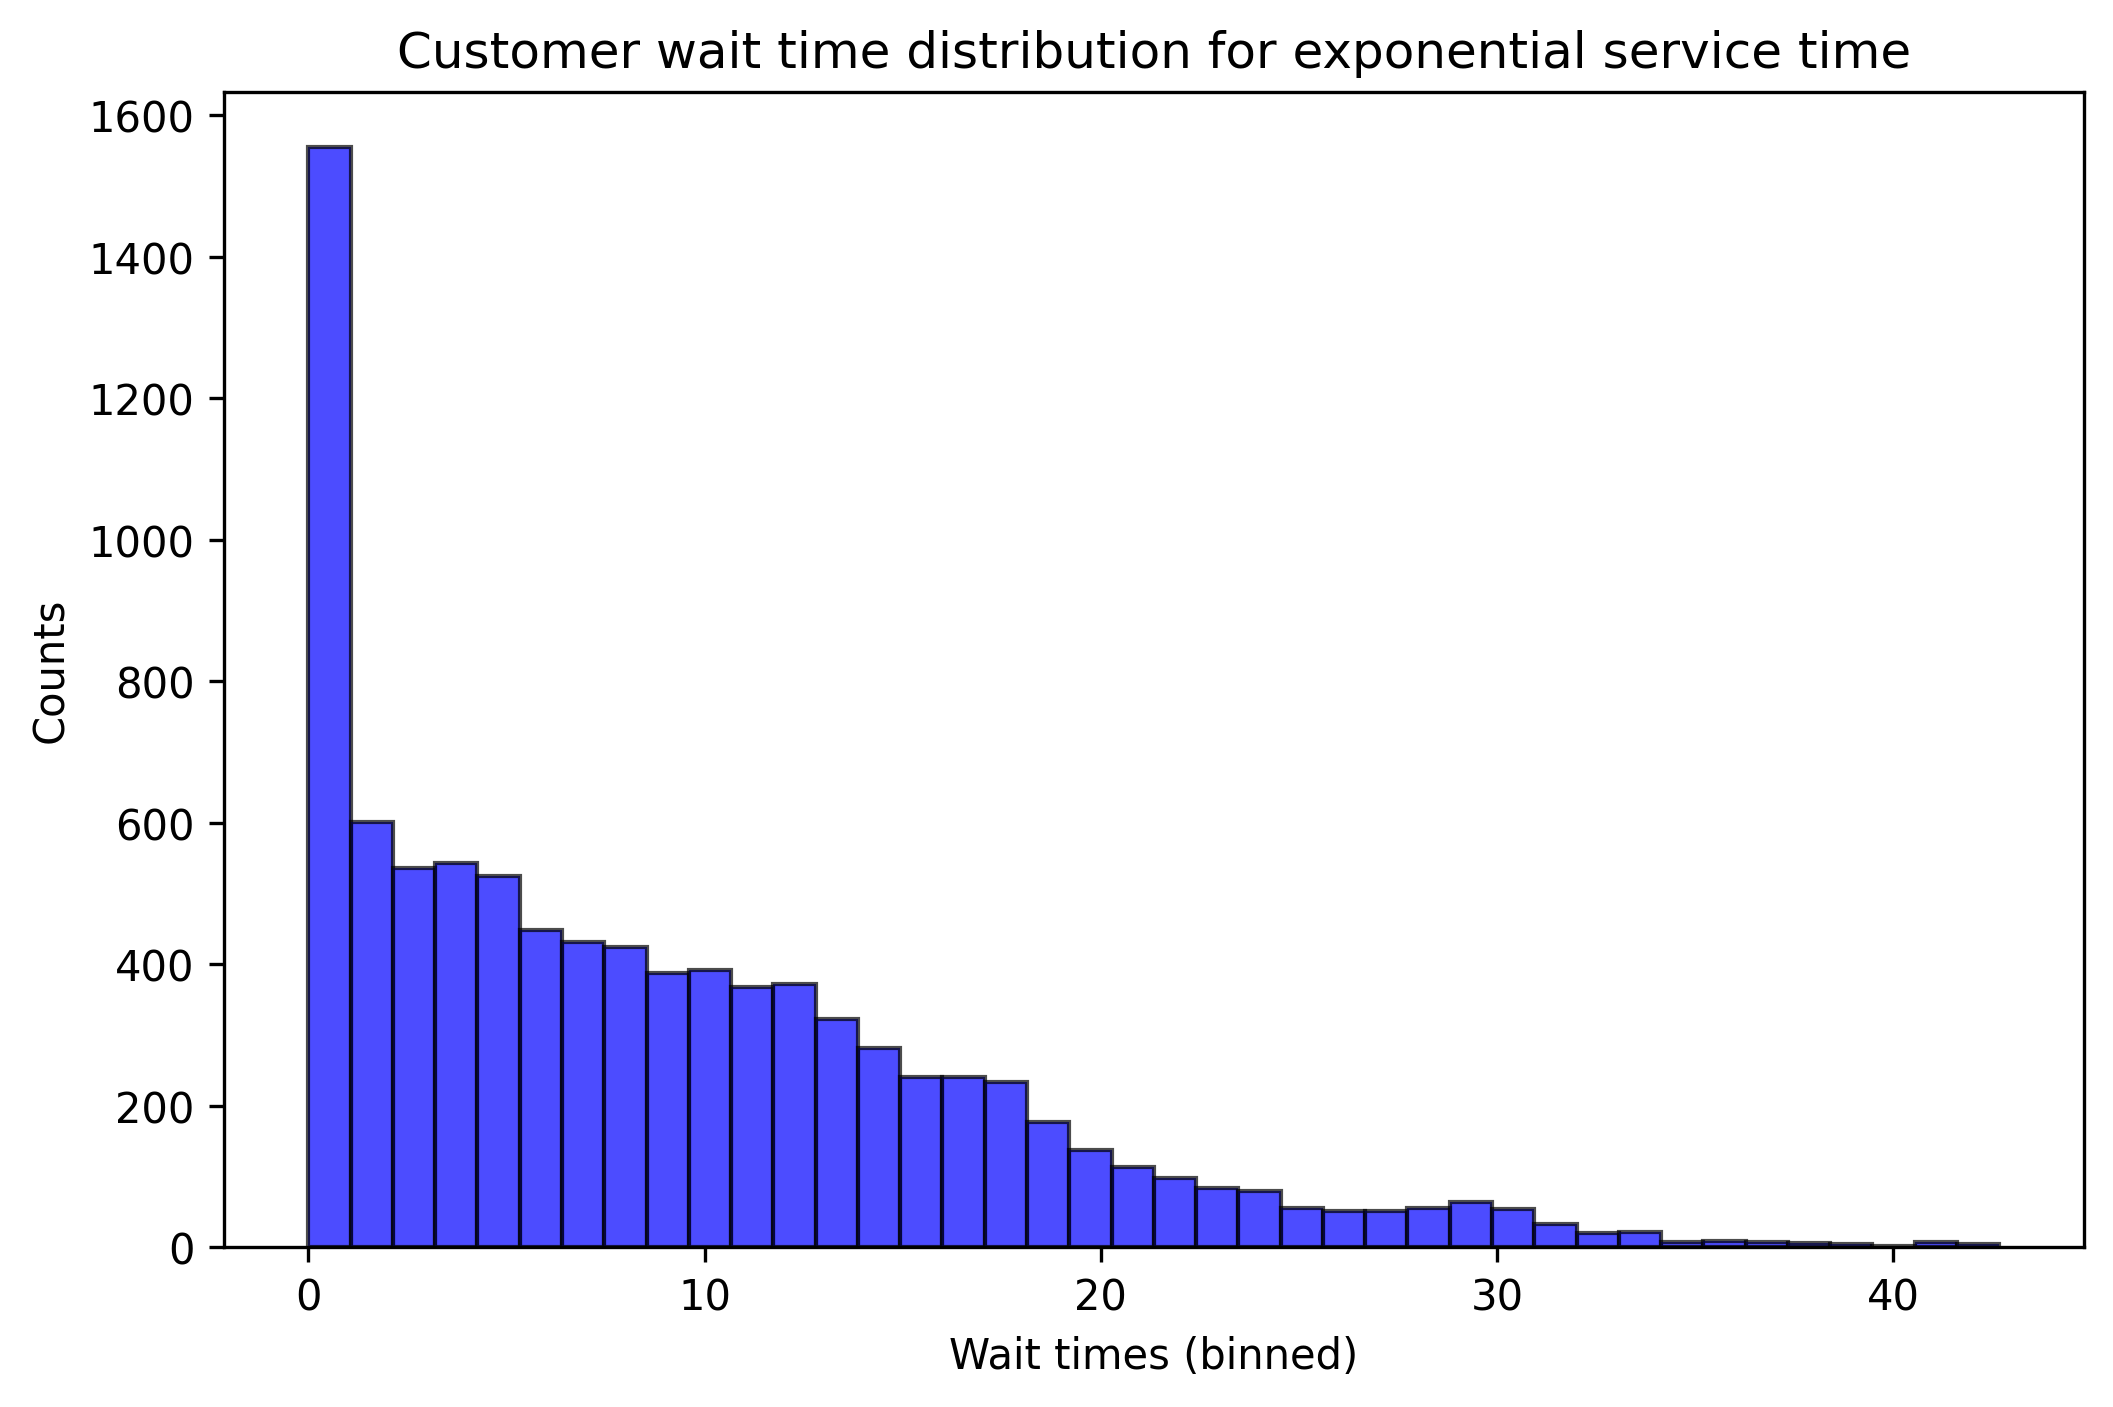

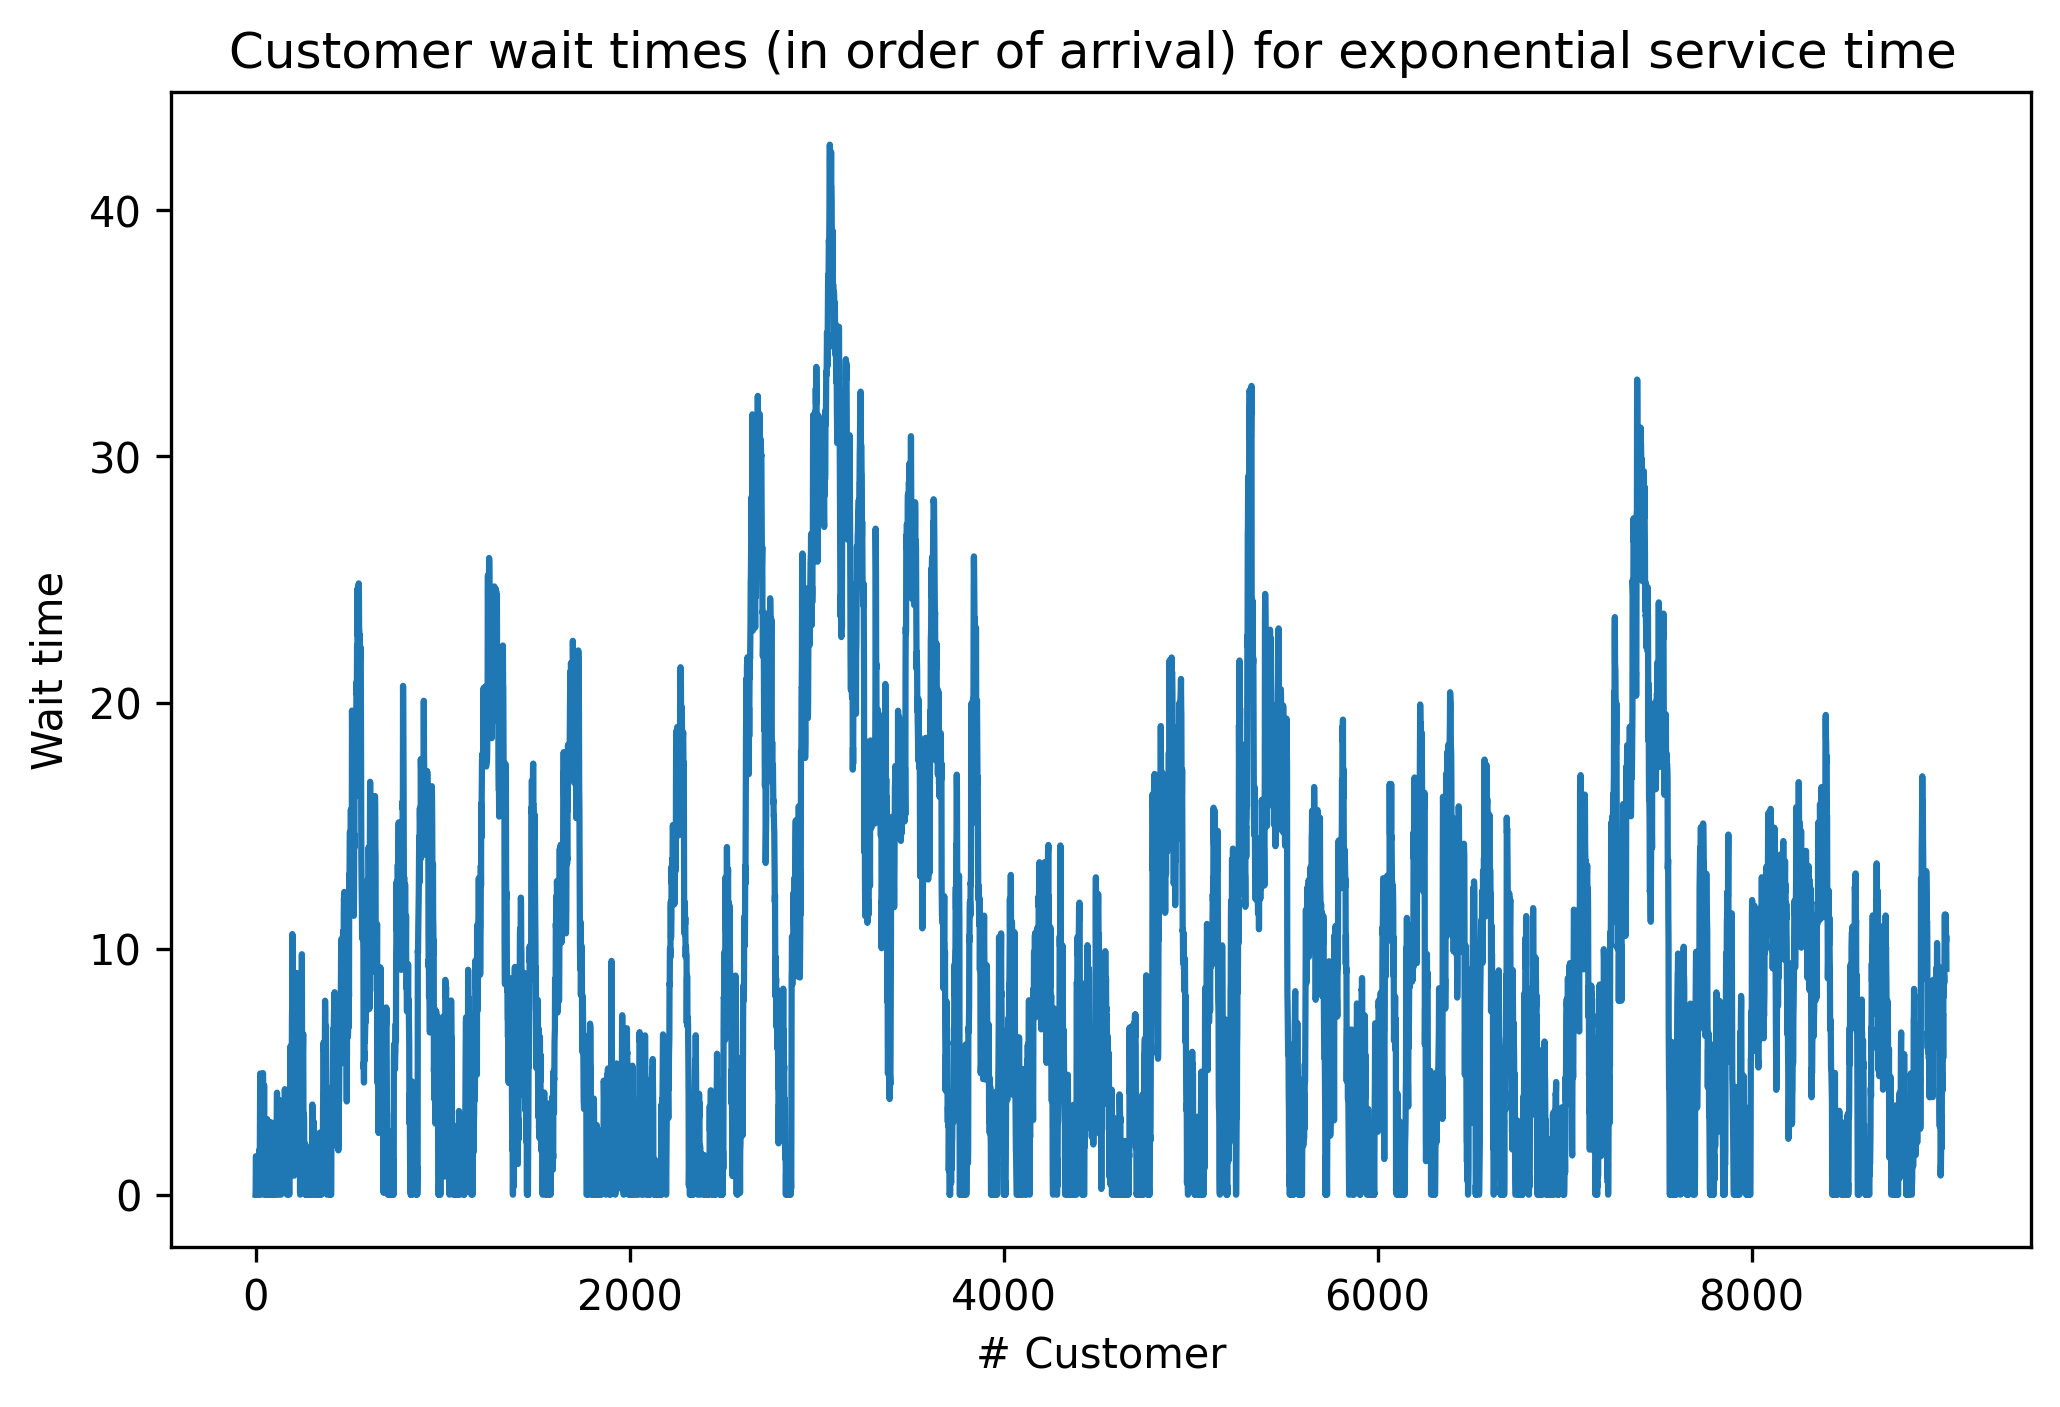

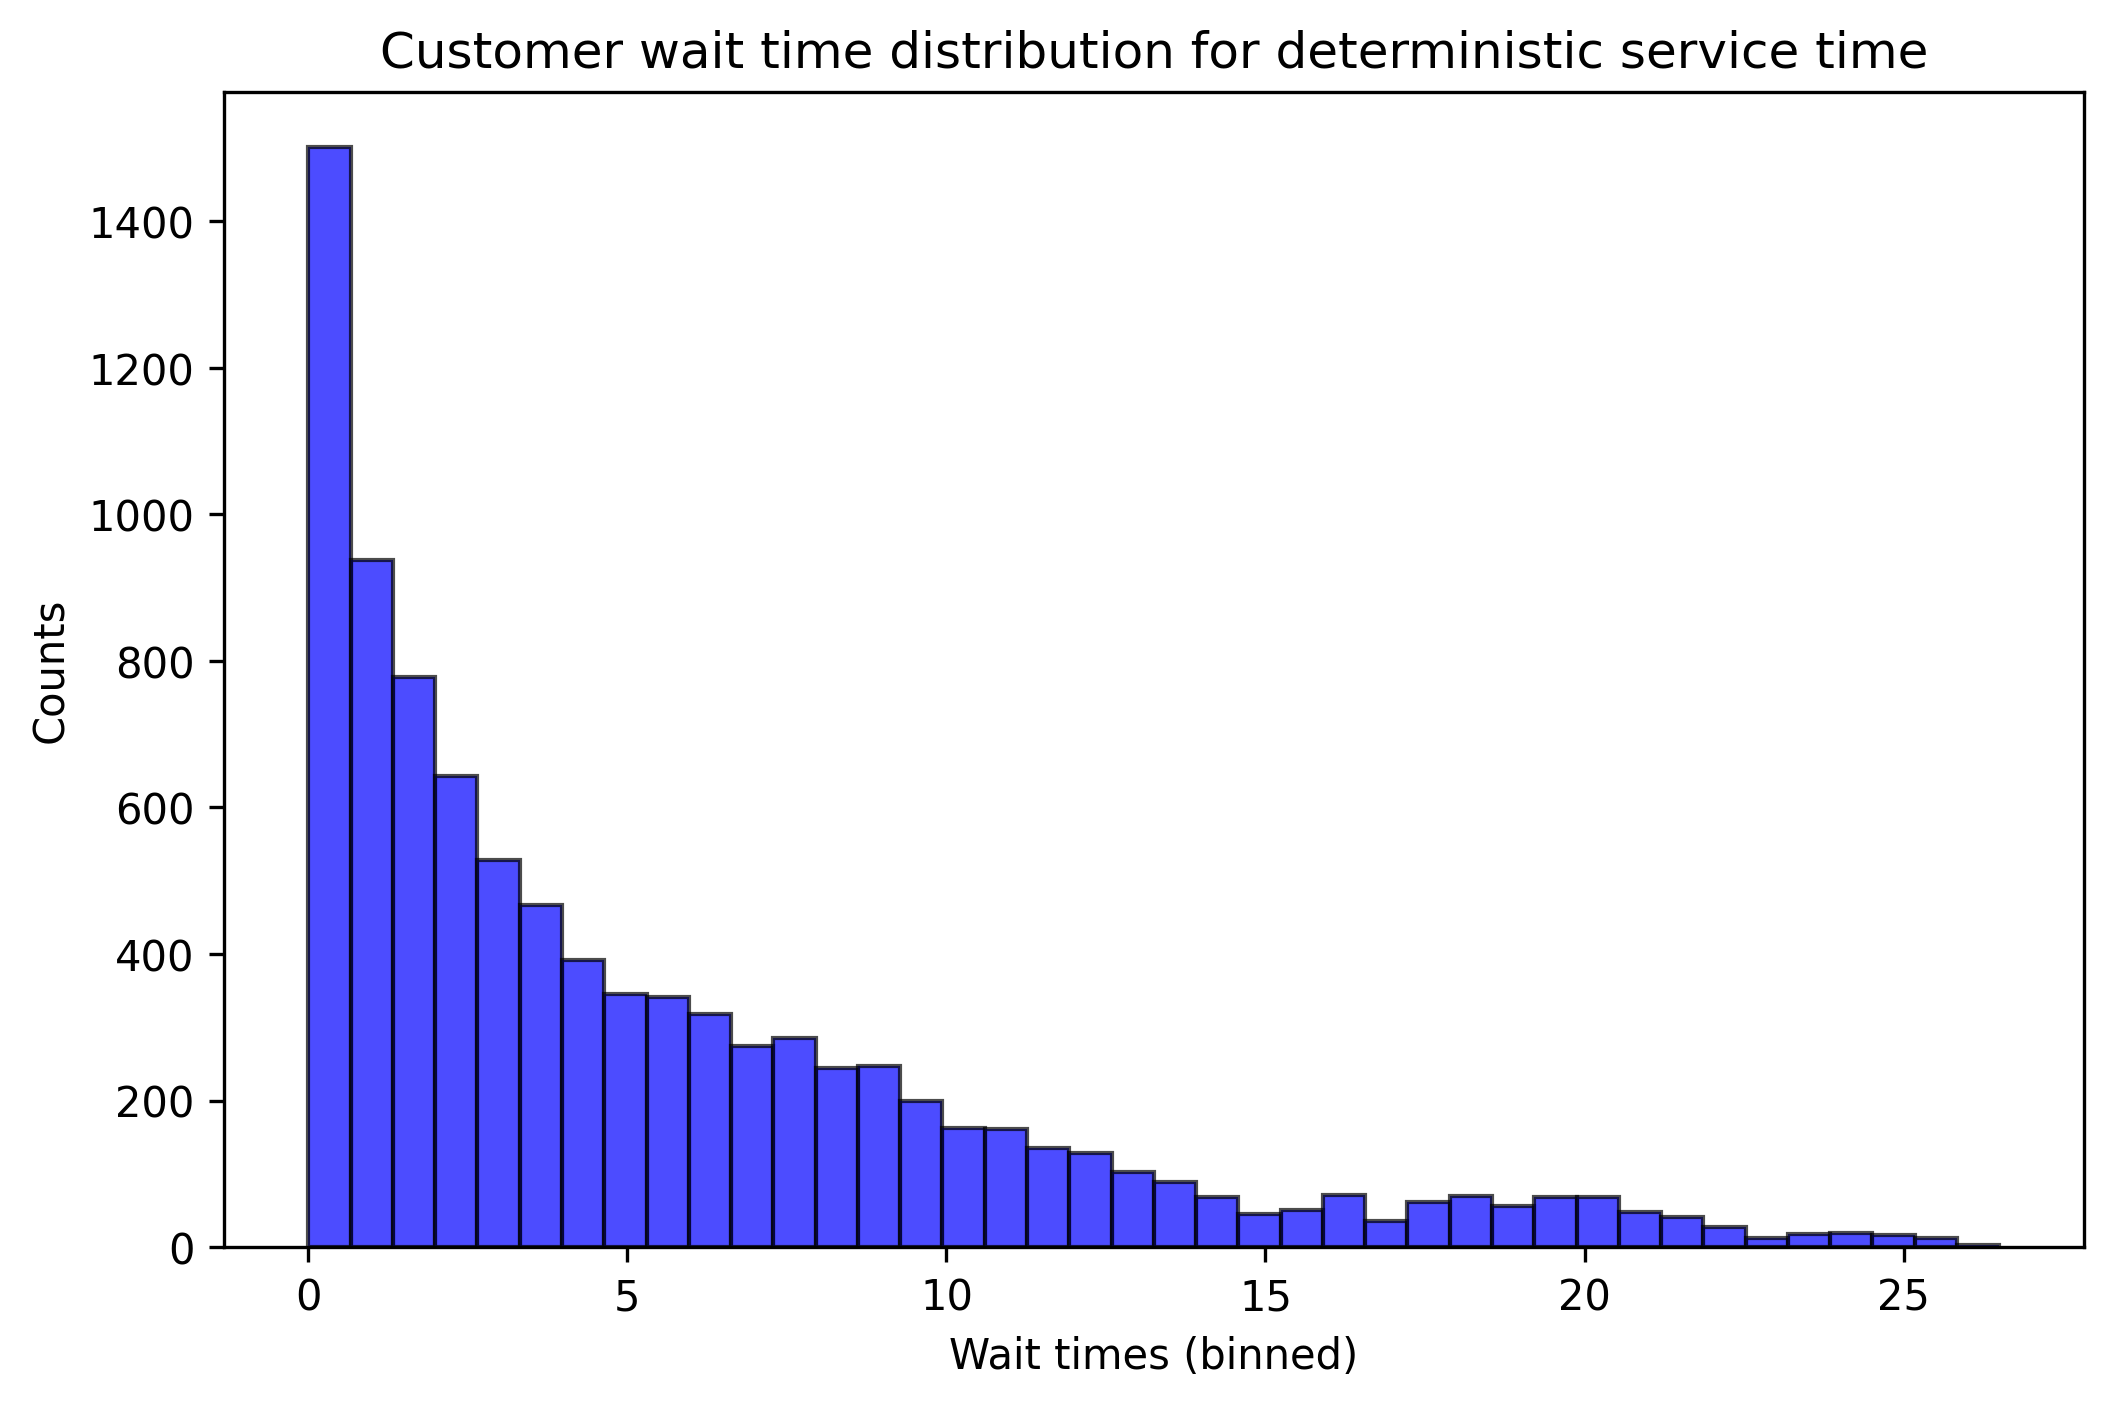

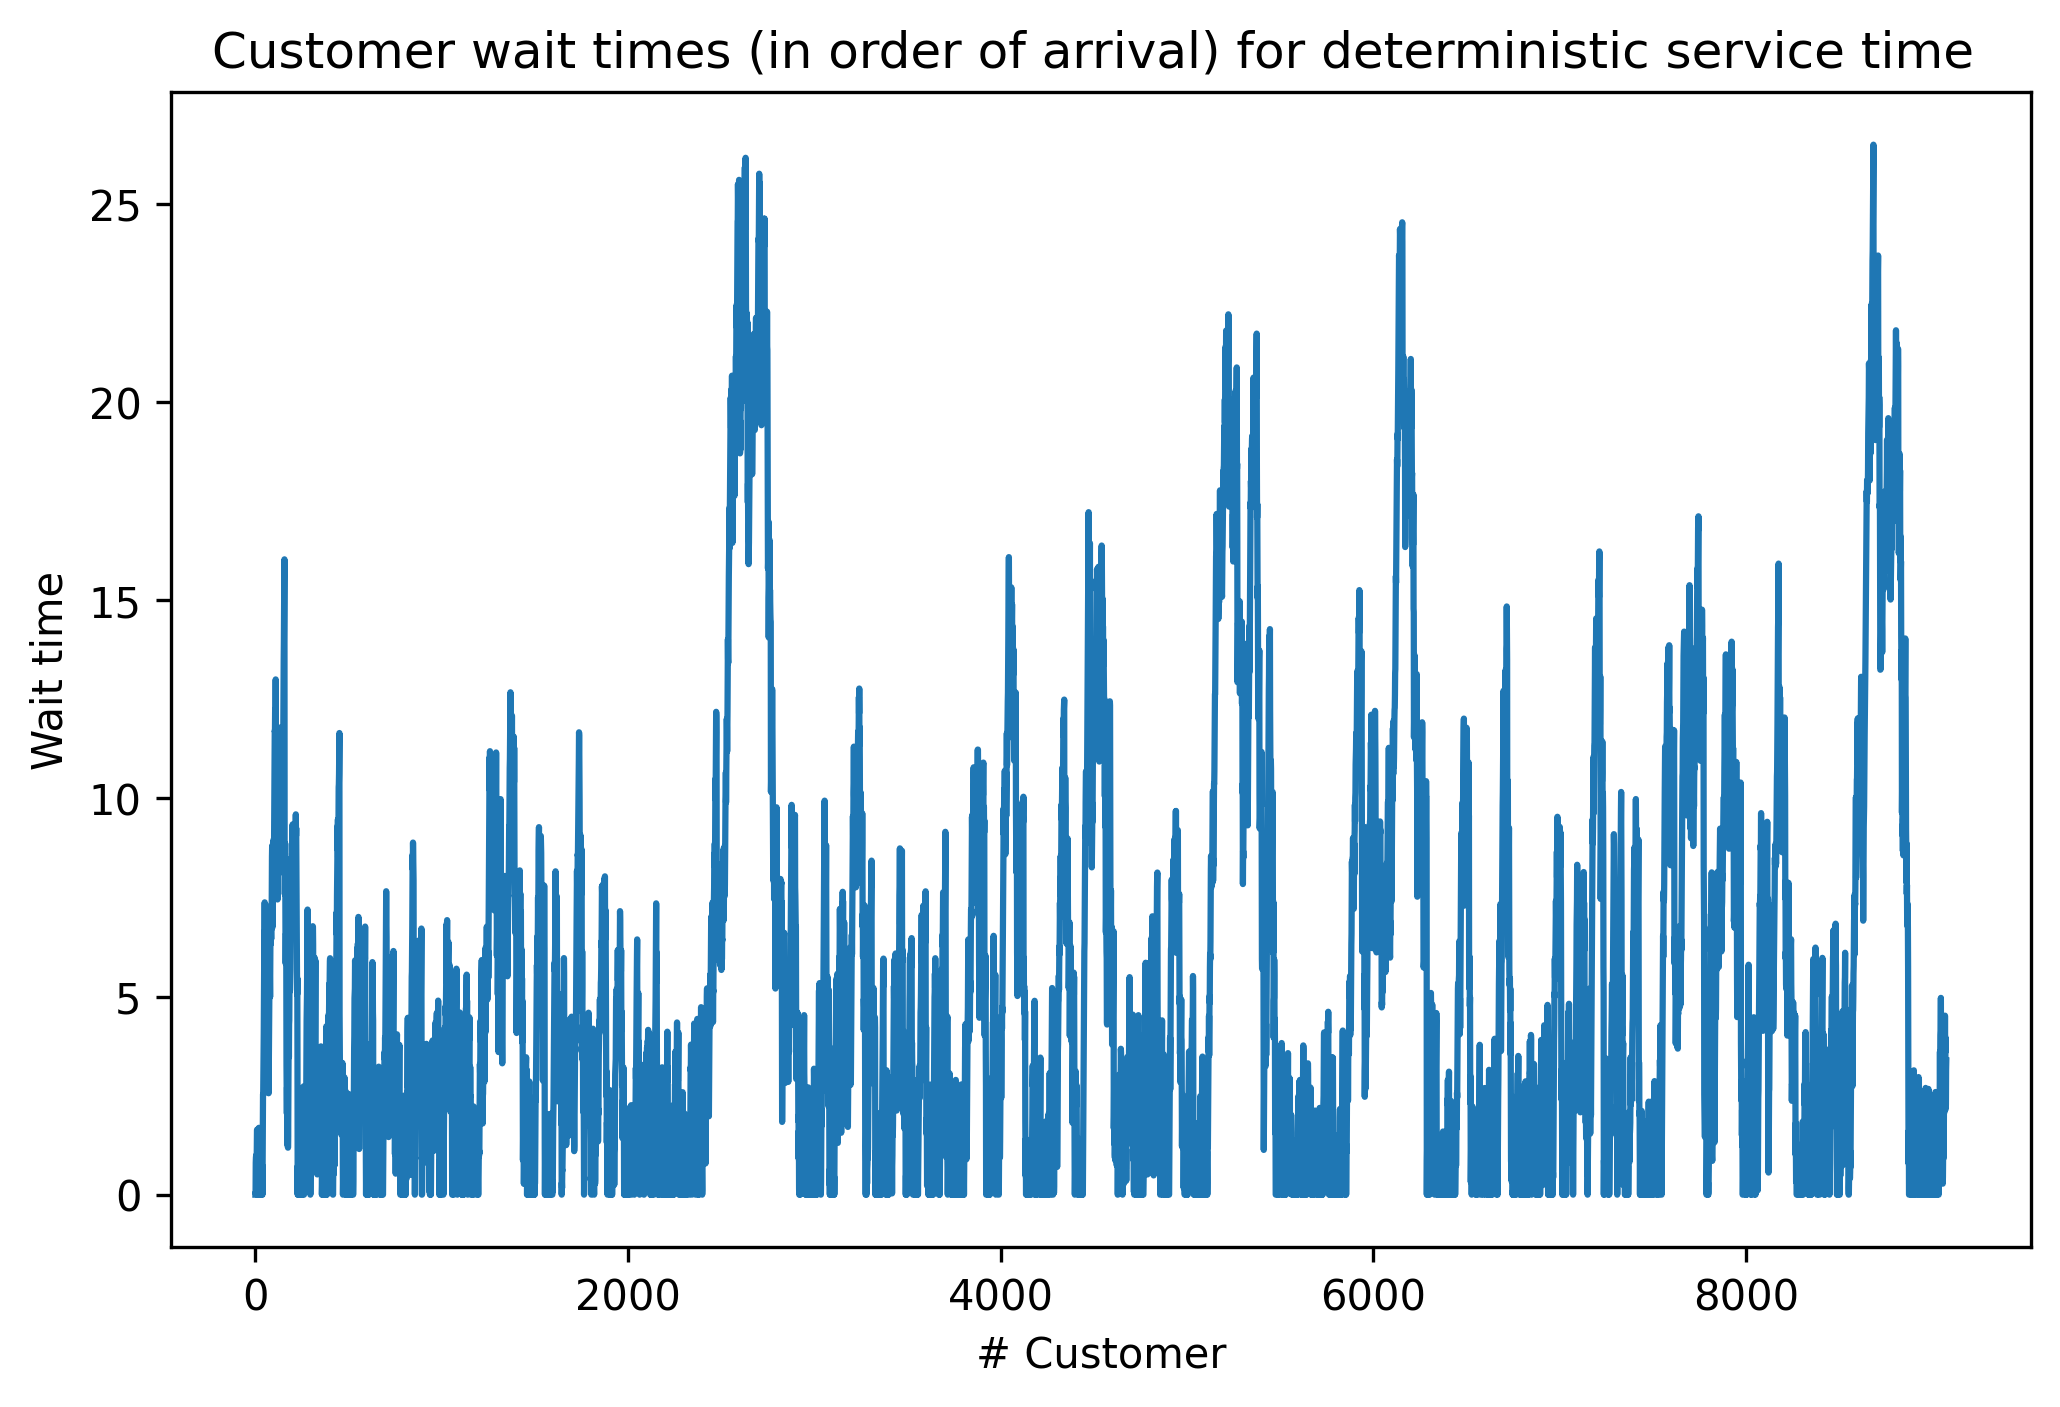

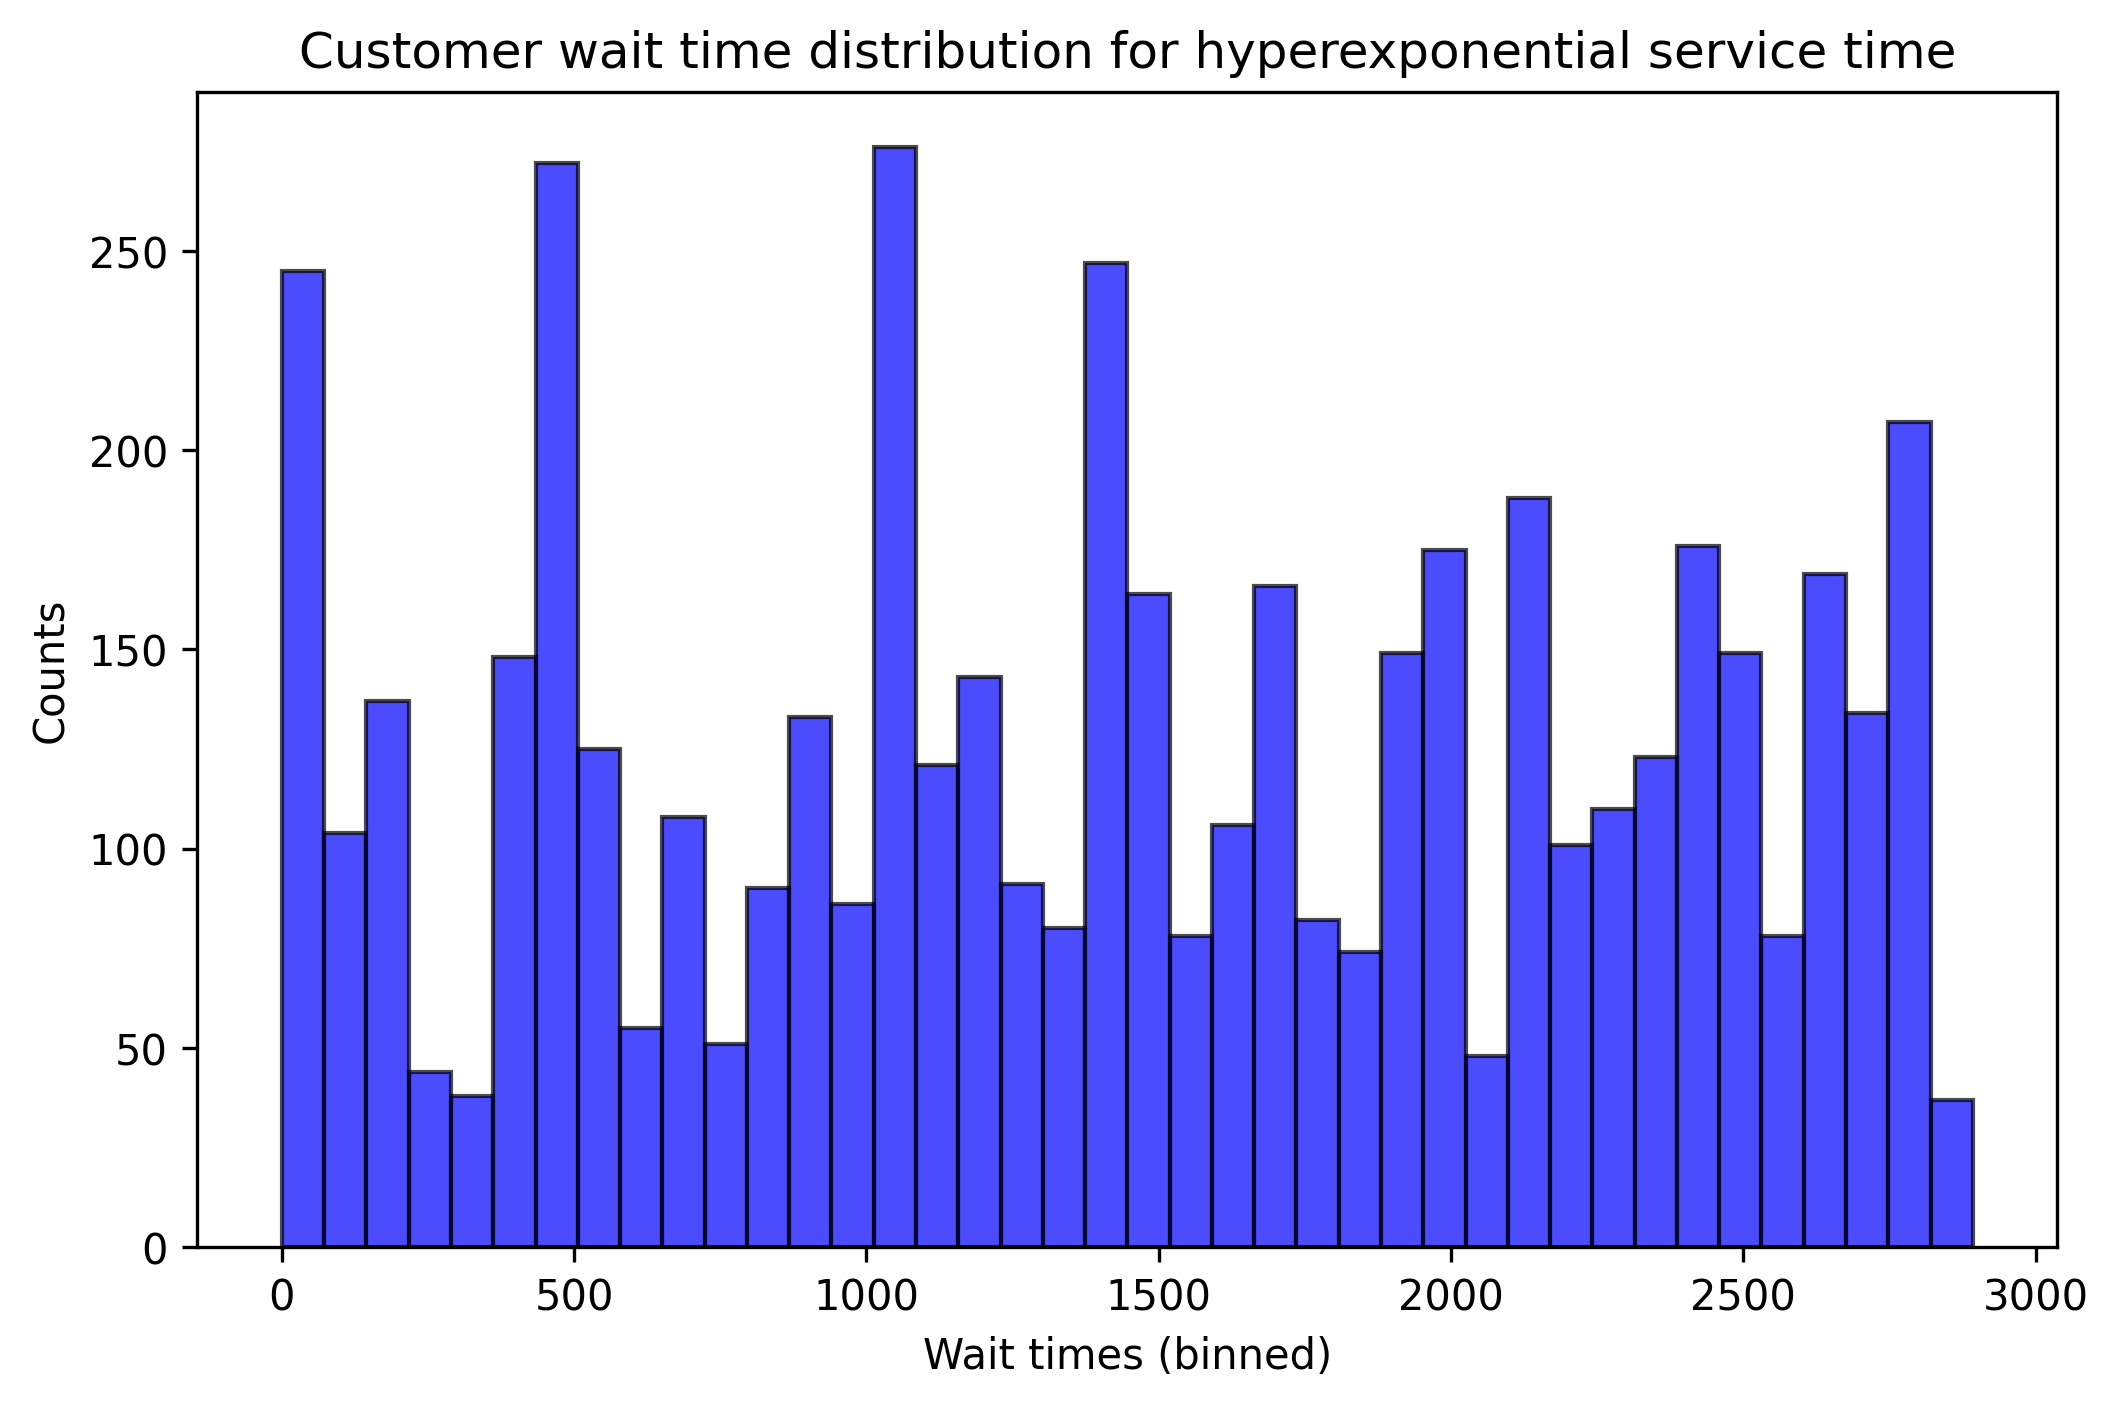

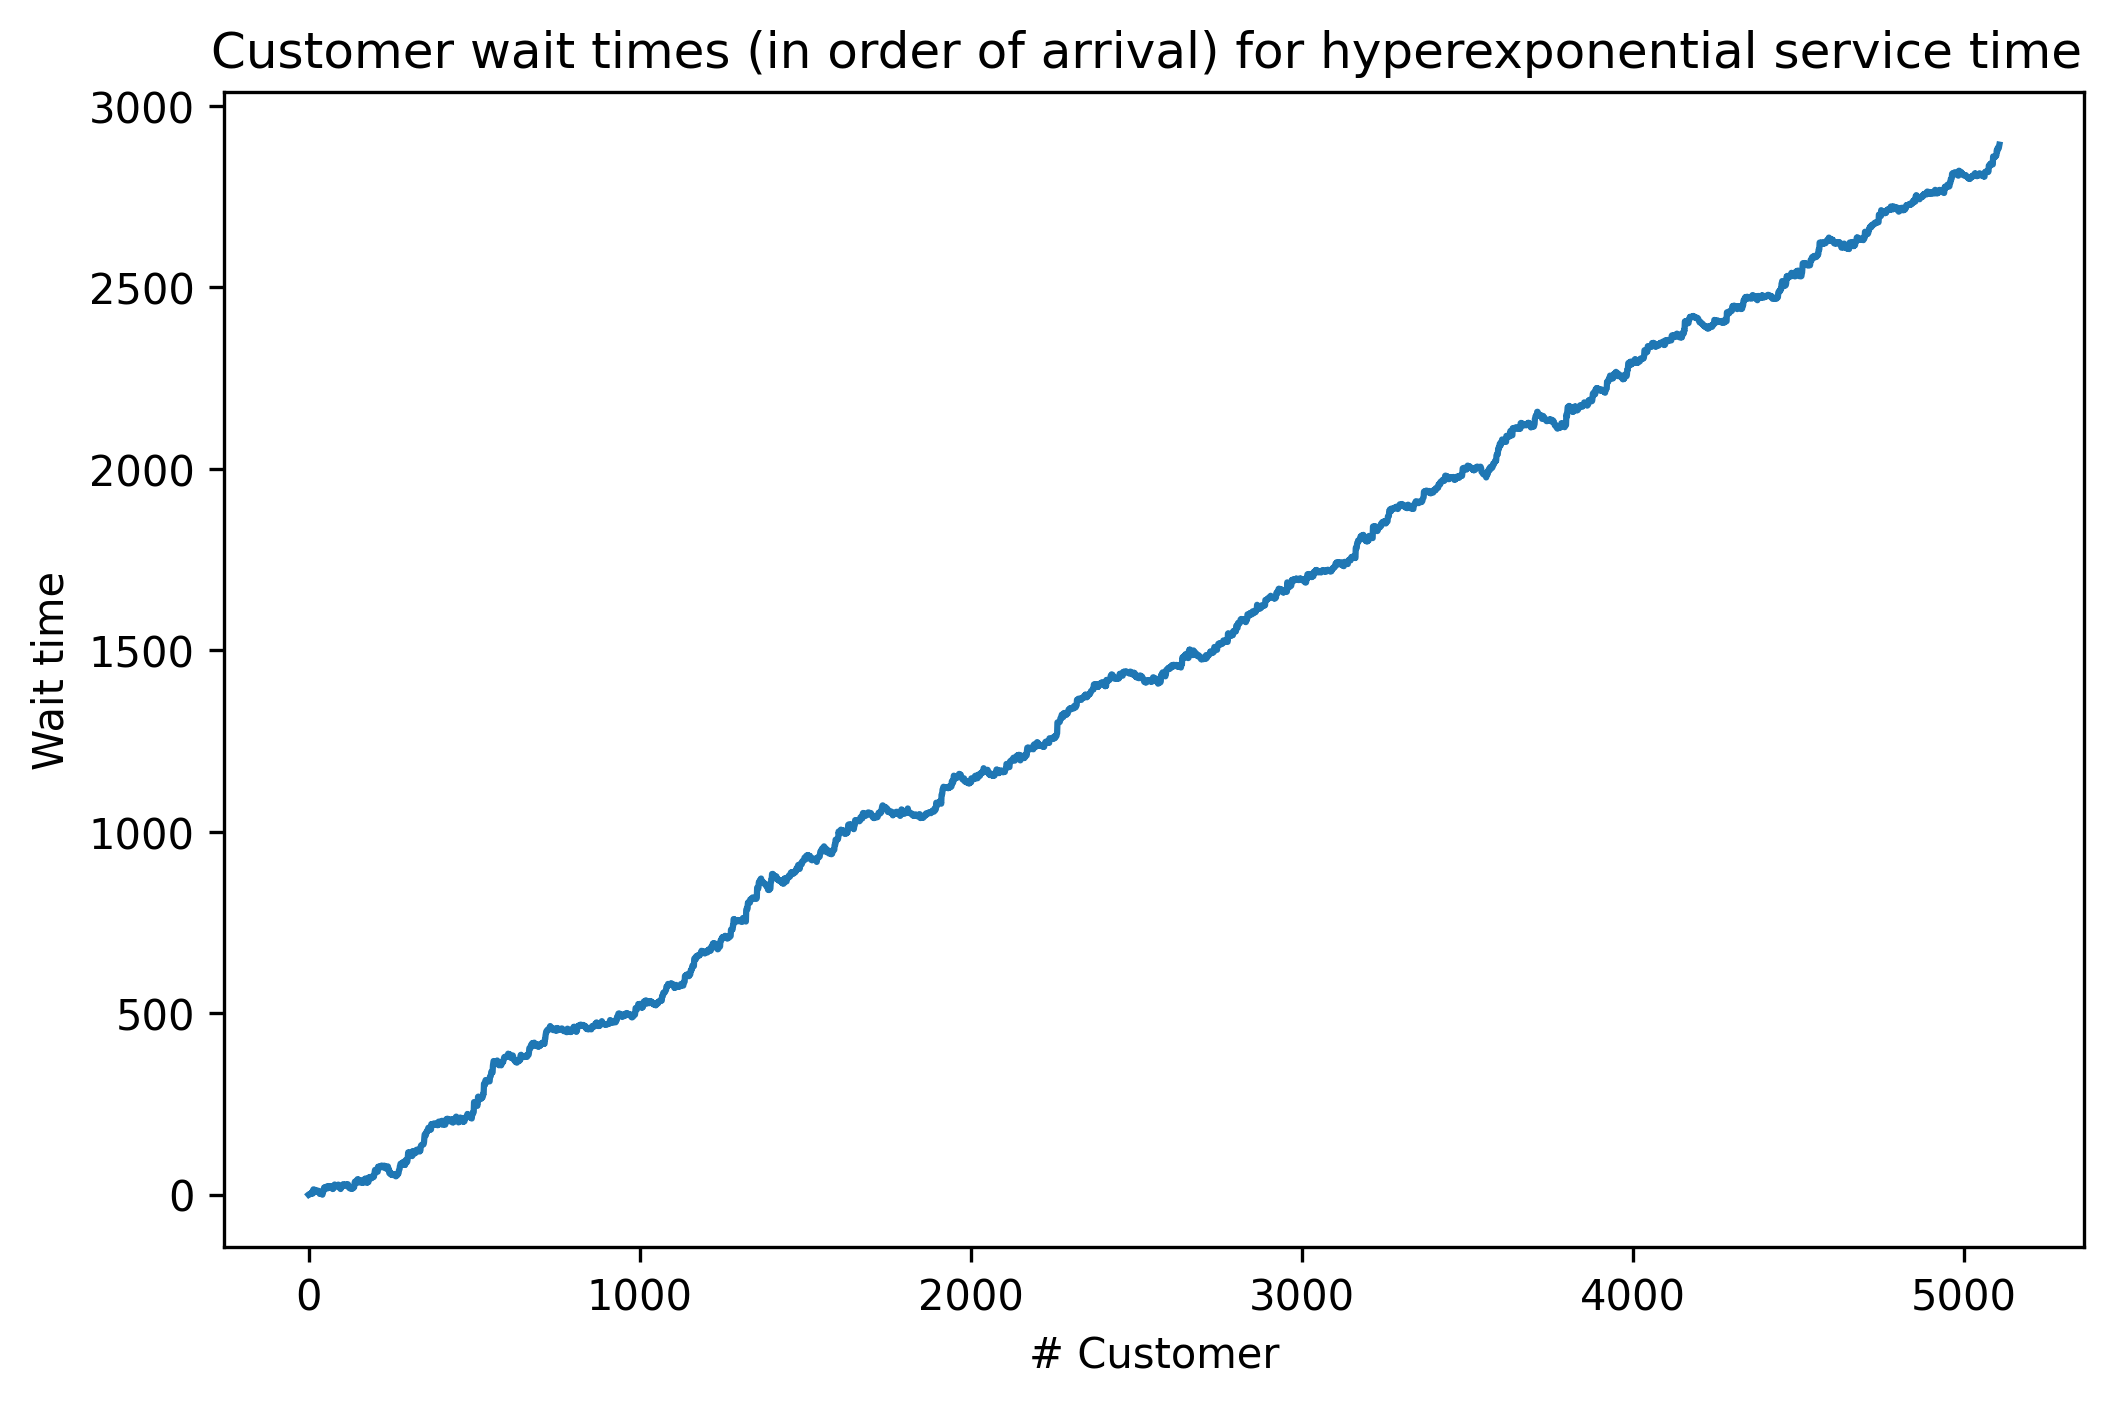

In [18]:
# Parameters
RANDOM_SEED = 42

def plot_simulation_waits(n_servers, sim_time, service_rate, service_time_distribution):
    arrival_rate = 0.9 * n_servers * service_rate
    _, wait_times = simulate(n_servers, arrival_rate, sim_time, priority=False, service_time_distribution=service_time_distribution)
    hist, bin_edges = np.histogram(wait_times, 40)
    plt.figure(figsize=(8, 5),dpi=300)
    
    plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Wait times (binned)')
    plt.ylabel('Counts')
    plt.title(f'Customer wait time distribution for {service_time_distribution} service time')
    
    plt.figure(figsize=(8, 5),dpi=300)
    plt.plot(wait_times)
    plt.ylabel('Wait time')
    plt.xlabel('# Customer')
    plt.title(f'Customer wait times (in order of arrival) for {service_time_distribution} service time ')
    
plot_simulation_waits(1,10000, 1, 'exponential')
plot_simulation_waits(1,10000, 1, 'deterministic')
plot_simulation_waits(1,10000, 0.8, 'hyperexponential') # Mean value of used hyperexponential distribution is 0.8

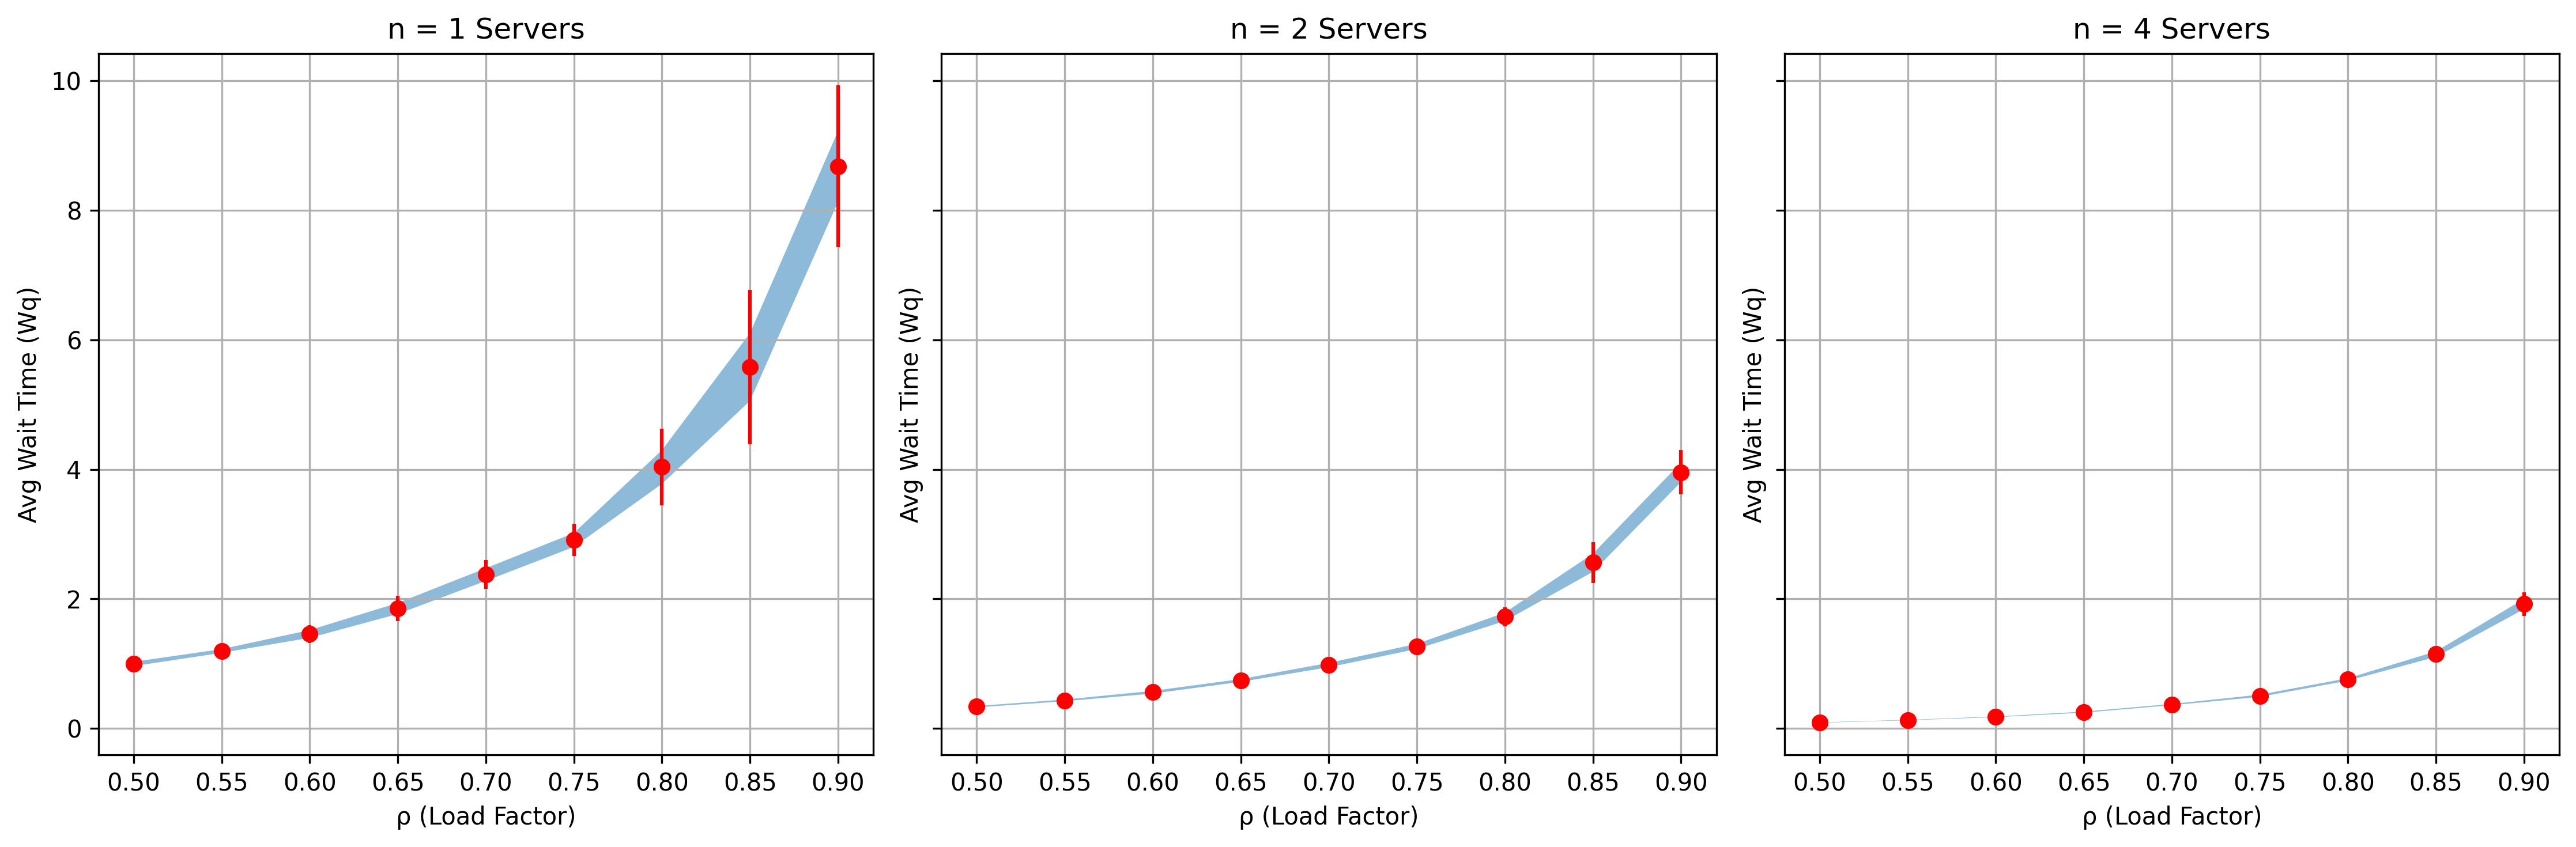

In [22]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
LOAD_VALUES = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        # lambda = rho * n *  nu
        # nu = service capacity
        arrival_rate = rho * n_servers * SERVICE_RATE

        for _ in range(n_runs):
            avg_wait, _ = simulate(n_servers, arrival_rate, sim_time, priority=False)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list),figsize=(15, 5), dpi=300, sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, LOAD_VALUES, N_RUNS, SIM_TIME)
    conf95_list = []
    means_list = []
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in LOAD_VALUES:
        avg_waits = results[rho]
        # axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        conf95 = 1.96 * std_wait / np.sqrt(N_RUNS)
        conf95_list.append(conf95)
        means_list.append(mean_wait)
        #axes[i].plot(rho, mean_wait, color='red')
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    means_list = np.array(means_list)
    conf95_list = np.array(conf95_list)
    axes[i].fill_between(LOAD_VALUES, y1=(means_list - conf95_list), y2=(means_list + conf95_list), alpha=0.5, linewidth=0)
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

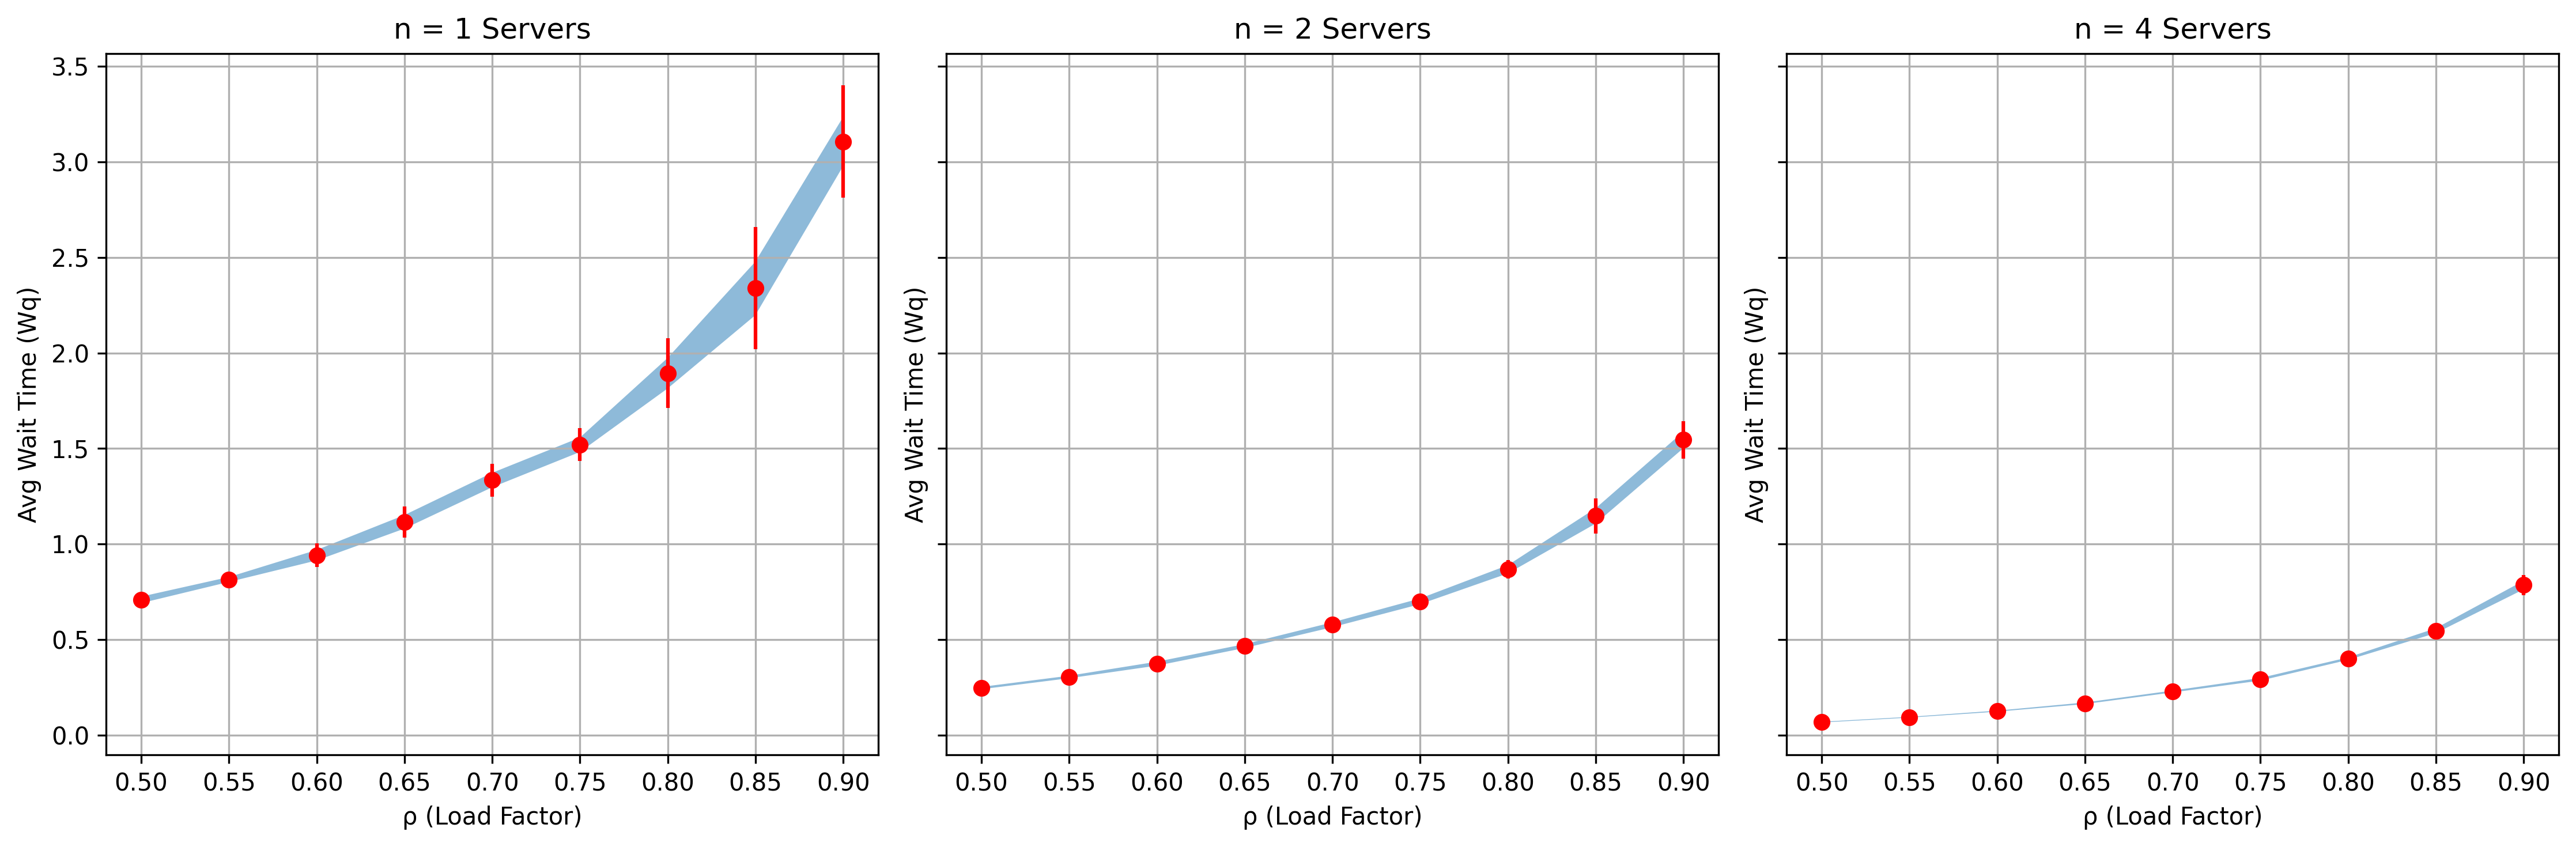

In [23]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
LOAD_VALUES = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        # lambda = rho * n *  nu
        # nu = service capacity
        arrival_rate = rho * n_servers * SERVICE_RATE

        for _ in range(n_runs):
            avg_wait, _ = simulate(n_servers, arrival_rate, sim_time, priority=True)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list),figsize=(15, 5), dpi=300, sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, LOAD_VALUES, N_RUNS, SIM_TIME)
    conf95_list = []
    means_list = []
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in LOAD_VALUES:
        avg_waits = results[rho]
        # axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        conf95 = 1.96 * std_wait / np.sqrt(N_RUNS)
        conf95_list.append(conf95)
        means_list.append(mean_wait)
        #axes[i].plot(rho, mean_wait, color='red')
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    means_list = np.array(means_list)
    conf95_list = np.array(conf95_list)
    axes[i].fill_between(LOAD_VALUES, y1=(means_list - conf95_list), y2=(means_list + conf95_list), alpha=0.5, linewidth=0)
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
LOAD_VALUES = [0.5,0.8,0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

def conduct_t_test(amount_runs=20):
    """
    This function conducts a t test for all combinations of n_servers and ρ values.
    It returns the results of the simulation and the t test.

    :param amount_runs: the amount of runs to conduct for each combination

    :return: results, t_test_results
    """
    # set the seed
    np.random.seed(RANDOM_SEED)

    results = {n: {p: [] for p in LOAD_VALUES} for n in n_servers_list}

    # conduct the simulations and save the results
    for n_servers in n_servers_list:
        for i, p in enumerate(LOAD_VALUES):
            # get the results per rho
            arrival_rate = p * n_servers * SERVICE_RATE
            for i in range(amount_runs):
                avg_wait, _ = simulate(n_servers, arrival_rate, SIM_TIME, priority=False)
                results[n_servers][p].append(avg_wait)

    # test if the results are normally distributed
    for n in n_servers_list:
        for p in LOAD_VALUES:
            if shapiro(results[n][p])[1] < 0.05:
                print("n={}, ρ={} is not normally distributed, with a value of {}".format(n, p, shapiro(results[n][p])[1]))
                #plot the distribution
                plt.hist(results[n][p])
                plt.show()

    t_test_results = {}
    # conduct the t tests
    for n1 in n_servers_list:
        for n2 in n_servers_list:
            if n1 != n2:
                for p in LOAD_VALUES:
                    t_stat, p_value = ttest_ind(results[n1][p], results[n2][p], equal_var=False, alternative='less')
                    t_test_results[(n1, n2, p)] = (t_stat, p_value)
                    if p_value < 0.05:
                        print("Waiting times for n={} are significantly less than n={} for ρ={} with a p_value of {}".format(n1, n2, p, p_value))

    return results, t_test_results

results, t_test_results = conduct_t_test(amount_runs=20)

Waiting times for n=2 are significantly less than n=1 for ρ=0.5 with a p_value of 2.050114653124911e-21
Waiting times for n=2 are significantly less than n=1 for ρ=0.8 with a p_value of 4.143046070677387e-18
Waiting times for n=2 are significantly less than n=1 for ρ=0.9 with a p_value of 9.53245356977729e-10
Waiting times for n=4 are significantly less than n=1 for ρ=0.5 with a p_value of 1.8492725606350917e-22
Waiting times for n=4 are significantly less than n=1 for ρ=0.8 with a p_value of 4.933532139448091e-19
Waiting times for n=4 are significantly less than n=1 for ρ=0.9 with a p_value of 3.0166840531119386e-12
Waiting times for n=4 are significantly less than n=2 for ρ=0.5 with a p_value of 8.844355773921308e-25
Waiting times for n=4 are significantly less than n=2 for ρ=0.8 with a p_value of 5.769678052899183e-17
Waiting times for n=4 are significantly less than n=2 for ρ=0.9 with a p_value of 6.252470511457988e-15


In [ ]:
# Experiment with different service rate distributions

# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
LOAD_VALUES = [0.5,0.8,0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server) - 0.8 for hyperexponential
N_RUNS = 20  # Number of stochastic runs per configuration

service_times = ['deterministic', 'exponential', 'hyperexponential']

def type_t_test(amount_runs=20):
    """
    This function conducts a t test for all combinations of service times at set n, rho = 0.9.
    It returns the results of the simulation and the t test.

    :param amount_runs: the amount of runs to conduct for each combination

    :return: results, t_test_results
    """
    # set the seed
    np.random.seed(RANDOM_SEED)

    results = {d: {n: [] for n in n_servers_list} for d in service_times}

    # conduct the simulations and save the results
    for n_servers in n_servers_list:
        for i, distib_type in enumerate(service_times):
            # get the results per service time distribution type
            arrival_rate = 0.9 * n_servers * SERVICE_RATE
            if distib_type == 'hyperexponential':
                arrival_rate = 0.9 * n_servers * 0.8
            for i in range(amount_runs):
                avg_wait, _ = simulate(n_servers, arrival_rate, SIM_TIME, priority=False, service_time_distribution= distib_type)
                results[distib_type][n_servers].append(avg_wait)

    t_test_results = {}
    # conduct the t tests
    for d1 in service_times:
        for d2 in service_times:
            if d1 != d2:
                for n in n_servers_list:
                    t_stat, p_value = ttest_ind(results[d1][n], results[d2][n], equal_var=False, alternative='less')
                    t_test_results[(d1, d2, n)] = (t_stat, p_value)
                    if p_value < 0.05:
                        print("Waiting times for {} service times are significantly less than {} @ n={} with a p_value of {}".format(d1, d2, n, p_value))

    return results, t_test_results

results, t_test_results = type_t_test(amount_runs=20)

Waiting times for deterministic service times are significantly less than exponential @ n=1 with a p_value of 1.0054313482565664e-09
Waiting times for deterministic service times are significantly less than exponential @ n=2 with a p_value of 1.1610731850705094e-19
Waiting times for deterministic service times are significantly less than exponential @ n=4 with a p_value of 1.2533221827787044e-18
Waiting times for deterministic service times are significantly less than hyperexponential @ n=1 with a p_value of 9.150261267467562e-24
Waiting times for deterministic service times are significantly less than hyperexponential @ n=2 with a p_value of 1.2620748977889502e-25
Waiting times for deterministic service times are significantly less than hyperexponential @ n=4 with a p_value of 2.589261704264214e-32
Waiting times for exponential service times are significantly less than hyperexponential @ n=1 with a p_value of 9.458963715853626e-24
Waiting times for exponential service times are signif